<a href="https://colab.research.google.com/github/ewst22ParkSY/ESAA11_PSY/blob/ESAA11_OB/ESAA_OB_WEEK1_2_transcript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5. 규제가 있는 선형 모델

- 과대적합을 감소시키는 좋은 방법은 모델을 규제하는 것.
- 자유도를 줄이면 데이터에 과대적합되기 더 어려워짐

다항 회귀 모델을 규제하는 간단한 방법은 다항식의 차수를 감소시키는 것

ex) '릿지', '라쏘', 엘라스틱넷 회귀

### 5.1 릿지 회귀

릿지회귀
- 규제가 추가된 선형 회귀 버전
- 규제항 $aΣ_{i=1}^n\theta_i^2$이 비용함수로 추가 (훈련하는 동안에만 비용 함수에 추가)
- 학습알고리즘을 데이터에 맞추는 것뿐만 아니라 모델의 가중치가 가능한 한 작게 유지되도록 노력
- 모델의 훈련이 끝나면 모델의 성능을규제가 없는 성능 지표로 평가

하이퍼 파라미터 $\alpha$: 모델을 얼마나 많이 규제할지 조절
- $\alpha=0$인 경우, 릿지 회귀 = 선형 회귀
-  $\alpha$가 아주 큰 경우, 가중치가 0에 가까워지고 데이터의 평균을 지나는 수평선이 됨.

릿지 회귀의 비용함수    
> $J(\theta) = MSE(\theta) + \alpha \frac{1}{2}Σ_{i=1}^n\theta_i^2$

편향 $\theta_0$는 규제되지 않음.

릿지 회귀 계산 방법 : 정규방정식 OR 경사 하강법

릿지 회귀의 정규방정식        
$\hat{\theta} = (X^TX+\alpha A)^{-1}X^Ty$


In [3]:
import numpy as np
import matplotlib.pyplot as plt

m = 100

X = 6 * np.random.rand(m, 1) -3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

In [5]:
# 사이킷런에서 정규방정식을 사용한 릿지 회귀를 적용하는 예

from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([5.03434106])

In [7]:
# 확률적 경사 하강법을 사용했을 때

from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(penalty="l2") #l2는 SGD가 비용 함수에 가중치 벡터의 노름의 제곱을 2로 나눈 규제항을 추가하게 만듦.
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])


array([4.99699829])

### 5.2 라쏘 회귀

- 선형 회귀의 또 다른 규제된 버전
- 비용 함수에 규제항을 더하지만, 가중치 벡터의 l2 노름을 사용.
- 중요 특징: 덜 중요한 특성의 가중치를 제거하려고 한다는 점
- 자동으로 특성 선택을 하고 희소 모델(sparse model)을 만듦.
> 0이 아닌 특성의 가중치가 적음.
- 경사 하강법이 최적점 근처에서 진동하는 것을 막으려면 훈련하는 동안 점진적으로 학습률을 감소시켜야 함.

라쏘의 비용 함수는 $\theta_i=0$에서 미분 가능하지 않음. 하지만 $\theta_i=0$에서 서브그라디언트 벡터 g를 사용하면 경사 하강법을 적용하는 데 문제가 없음.

In [8]:
# Lasso 클래스를 사용한 간단한 사이킷런 예제

from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.97668948])

참고: Lasso 대신 ```SGDRegressor(penalty="l2")```를 사용할 수도 있음.

### 5.3 엘라스틱넷
- 릿지 회귀와 라쏘 회귀를 절충한 모델
- 릿지와 회귀의 규제항을 단순히 더해서 사용하며, 혼합정도는 혼합 비율 r을 사용해 조절. r=0이면 엘라스틱넷은 릿지 회귀와 같고, r=1이면 라쏘 회귀와 같음.

엘라스틱넷을 선호하는 상황
- 특성 수가 훈련 샘플 수보다 많음 <br>
OR
- 특성 몇 개가 강하게 연관되어 있을 때



In [10]:
# 사이킷런의 ElasticNet을 사용한 간단한 예제

from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.97717918])

### 5.4 조기 종료(Early Stopping)
- 검증 에러가 최솟값에 도달하면 바로 훈련을 중지시키는 것
- 에포크가 진행됨에 따라 알고리즘이 점차 학습되어 훈련 세트에 대한 예측 에러(RMSE)와 검증 세트에 대한 예측 에러가 줄어듦. > 감소하던 검증 에러가 멈추었다가 다시 상승 > 모델이 훈련 데이터에 과대적합되기 시작됨을 의미



In [22]:
# 조기 종료를 위한 기본적인 구현 코드

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# 데이터 준비
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005)


minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled,y_train.ravel()) # 훈련을 이어서 진행
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

## 6. 로지스틱 회귀
- 샘플이 특정 클래스에 속할 확률을 추정하는 데 널리 사용
- 추정 확률이 50%가 넘을 시 속함, 아닐 시 속하지 않음이라 예측. > 이진 분류기

### 6.1 확률 추정
- 로지스틱 회귀 모델은 입력 특성의 가중치 합을 계산(+편향)
- 선형 회귀처럼 바로 결과를 출력하는 것이 아니라 결괏값의 **로지스틱**을 출력
- **로지스틱**은 0과 1 사이의 값을 출력하는 **시그모이드 함수**.(S자 형태)

### 6.2 훈련과 비용 함수
- 훈련의 목적: 양성 샘플(y=1)에 대해서는 높은 확률을 추정하고 음성 샘플(y=0)에 대해서는 낮은 확률을 추정하는 모델의 파라미터 벡터를 찾는 것.
- t가 0에 가까워지면 -log(t)가 매우 커지므로 타당 > 모델이 양성 샘플을 0에 가까운 확률로 추정하면 비용이 매우 크게 증가
- t가 1에 가까우면 -log(t)는 0에 가까워짐. > 기대한 대로 음성 샘플의 확률을 0에 가깝게 추정하거나 양성 샘플의 확률을 1에 가깝게 추정하면 비용은 0에 가까워짐.

로지스틱 회귀의 비용 함수       
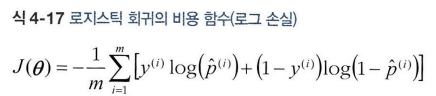

- 비용 함수의 최솟값을 계산하는 알려진 해가 없음. 하지만 볼록 함수이므로 경사하강법이 전역 최솟값을 찾는 것을 보장.

### 6.3 결정 경계

In [24]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

X = iris["data"][:, 3:] #꽃잎의 너비
y = (iris["target"] == 2).astype(int) #1 Iris-Virginica면 1, 그렇지 않으면 0

In [25]:
# 로지스틱 회귀 모델 훈련

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

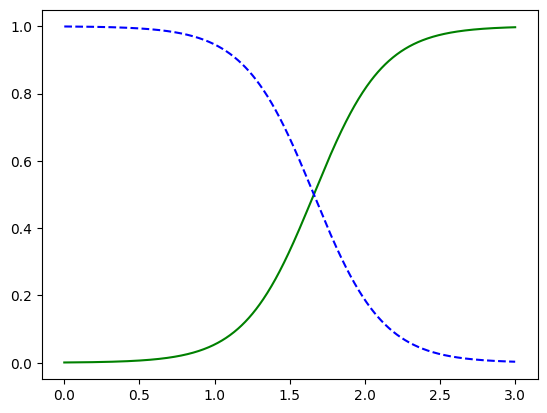

In [27]:
# 꽃잎의 너비가 0~3cm인 꽃에 대해 모델의 추정 확률
import matplotlib.pyplot as plt
import numpy as np

X_new = np.linspace(0, 3, 1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-", label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", label="Not Iris virginica")

# 다음은 이미지를 미려하게 출력하기 위한 맷플롯립 코드가 이어집니다.

In [28]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

### 6.4 소프트맥스 회귀

소프트맥스 회귀: 여러 개의 이진 분류기를 훈련시켜 연결하지 않고 직접 다중 클래스를 지원하도록 일반화

샘플 x가 주어지면 먼저 소프트맥스 회귀 모델이 각 클래스 k에 대한 점수 $s_k(x)$를 계산하고, 그 점수에 소프트맥스 함수를 적용하여 각 클래스의 확률을 추정.

훈련 방법
- 모델이 타깃 클래스에 대해서는 높은 확률을 추정하도록 만드는 것
- 크로스 엔트로피 비용 함수를 최소화하는 것 > 타깃 클래스에 대해 낮은 확률을 예측하는 모델을 억제



In [29]:
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10)
softmax_reg.fit(X, y)

softmax_reg.predict([[5, 2]])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


array([2])

In [30]:
softmax_reg.predict_proba([[5, 2]])

array([[6.21626375e-07, 5.73689803e-02, 9.42630398e-01]])